In [147]:
#!pip install fastai

In [146]:
# -- public imports

import os
from fastai.text import *
from fastai.text.all import *
import nltk
import spacy
import pandas as pd
import numpy as np
import fastai
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
tqdm.pandas()
print(f"fastai version: {fastai.__version__}")
if torch.cuda.is_available():
    print(f"GPU which is used : {torch.cuda.get_device_name(0)}")
    

fastai version: 2.5.5


# Import Dataset

In [139]:
base_path = '/Users/feng/downloads'
path = os.path.join(base_path, 'ArgumentAnnotatedEssays-2.0')
text_file_dir = os.path.join(path, 'brat-project-final')

texts = []
annotated_texts = []
for file in os.listdir(text_file_dir):
    essay_num, file_extension = file.split('.')
    if file_extension == 'ann':
        with open(os.path.join(text_file_dir, file), 'r') as f:
            df_temp = pd.read_csv(f, delimiter='\t', header=None, names=['label_type', 'label', 'text'])
            df_temp[['label', 'label_comp1', 'label_comp2']] = df_temp.label.str.split(expand=True)
            df_temp['doc_id'] = essay_num
            annotated_texts.append(df_temp)
    elif file_extension == 'txt':
        with open(os.path.join(text_file_dir, file), 'r') as f:
            texts.append((essay_num, f.read()))
    else:
        continue

df_texts = pd.DataFrame.from_records(texts, columns={'doc_id', 'text'})
df_annotated = pd.concat(annotated_texts)
assert sorted(df_annotated.doc_id.unique()) == sorted(df_texts.doc_id)

In [140]:
ids_argument_segment = df_annotated.label_type.str.startswith('T')

df_arguments = df_annotated[ids_argument_segment]

df_arguments.head()

,label_type,label,text,label_comp1,label_comp2,doc_id
0,T1,MajorClaim,alternative means of transportation and intern...,358,464,essay031
1,T2,MajorClaim,alternative forms of transport and internation...,2393,2565,essay031
2,T3,Claim,some people claim the convenience of automobile,2325,2372,essay031
4,T4,Claim,it is crucial to alter automobiles to the othe...,822,933,essay031
6,T5,Premise,an increase in the number of automobiles bring...,561,638,essay031


In [141]:
df_arguments = df_arguments.rename(columns={'label_comp1':'span_start', 'label_comp2':'span_end'}).astype(
    {'span_start': int, 'span_end':int}
)
df_arguments.dtypes

label_type    object
label         object
text          object
span_start     int64
span_end       int64
doc_id        object
dtype: object

In [142]:
records = []
df_arguments = df_arguments.sort_values(['doc_id', 'span_start', 'span_end'])
for (doc_id, text) in df_texts.sort_values('doc_id').itertuples(index=False):
    df_argument = df_arguments[df_arguments.doc_id == doc_id]
    prev_span = 0
    for i, (text_segment, span_start, span_end) in enumerate(df_argument[['text', 'span_start', 'span_end']].itertuples(index=False)):
        try:
            assert text_segment == text[span_start: span_end]
        except Exception as e:
            print(f'{text_segment}\n{text[span_start: span_end]}\n')
        # all the exception were manually checked. These are because of qutoe chars, this is a hot fix.!!!! TODO
            df_arguments['text'][df_arguments.text == text_segment] = text[span_start: span_end]
        records.append(('O', 'Other', text[prev_span: span_start], prev_span, span_start, doc_id))
        prev_span = span_end
    records.append(('O', 'Other', text[prev_span:], prev_span, len(text), doc_id))
df_other = pd.DataFrame.from_records(records, columns=df_arguments.columns)
df_other

murdering criminals is therefore immoral and hard to accept
"murdering" criminals is therefore immoral and hard to accept

Click is a very interesting comedy, with a serious approach about the importance of having a balanced life between family and work businesses
"Click" is a very interesting comedy, with a serious approach about the importance of having a balanced life between family and work businesses

Blood diamond, an adaptation of a real story in South Africa, focuses on the link between diamonds and conflict
"Blood diamond", an adaptation of a real story in South Africa, focuses on the link between diamonds and conflict



<ipython-input-142-d17e5c1ade51>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arguments['text'][df_arguments.text == text_segment] = text[span_start: span_end]


rush hours are usually not the direct consequence of drivers
"rush hours" are usually not the direct consequence of drivers



,label_type,label,text,span_start,span_end,doc_id
0,O,Other,Should students be taught to compete or to coo...,0,503,essay001
1,O,Other,".\nFirst of all,",575,591,essay001
2,O,Other,.,714,716,essay001
3,O,Other,.,851,853,essay001
4,O,Other,.,1086,1088,essay001
...,...,...,...,...,...,...
6486,O,Other,.,1339,1341,essay402
6487,O,Other,", so",1388,1393,essay402
6488,O,Other,". Secondly,",1436,1448,essay402
6489,O,Other,". \nIn conclusion,",1525,1543,essay402


In [143]:
df_combined = pd.concat([df_other, df_arguments])
df_combined = df_combined.sort_values(['doc_id', 'span_start', 'span_end']).reset_index(drop=True)


In [148]:
df_combined

,label_type,label,text,span_start,span_end,doc_id
0,O,Other,"Should students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that",0,503,essay001
1,T1,MajorClaim,we should attach more importance to cooperation during primary education,503,575,essay001
2,O,Other,".\nFirst of all,",575,591,essay001
3,T3,Claim,"through cooperation, children can learn about interpersonal skills which are significant in the future life of all students",591,714,essay001
4,O,Other,.,714,716,essay001
...,...,...,...,...,...,...
12575,O,Other,". Secondly,",1436,1448,essay402
12576,T14,Premise,playing sport makes children getting healthy and become children's well-being,1448,1525,essay402
12577,O,Other,". \nIn conclusion,",1525,1543,essay402
12578,T2,MajorClaim,both studying hard at school and playing sports can improve children's future,1543,1620,essay402


In [150]:
ID2CLASS = dict(enumerate(df_combined['label'].unique().tolist()))
CLASS2ID = {v: k for k, v in ID2CLASS.items()}
# print(ID2CLASS)
CLASS2ID

{'Other': 0, 'MajorClaim': 1, 'Claim': 2, 'Premise': 3}

In [154]:
def convert_label(label):
    return CLASS2ID[label]

df_combined['label'] = df_combined['label'].apply(convert_label)

In [153]:
df_sample = df_combined.sample(n=500, random_state=2)
df_sample['label'].value_counts()
df_sample = df_sample[['text','label']]
df_sample

0    247
3    146
2     64
1     43
Name: label, dtype: int64

In [168]:
dls_lm = TextDataLoaders.from_df(df_sample, path=path,is_lm=True)
dls_lm.show_batch(max_n=3)

/Users/feng/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos games on their phone xxunk a xxunk xxunk on xxunk , xxunk to a large problem that they xxunk xxunk to their xxunk xxbos there is a fact that one can improve health xxunk with xxunk physical xxunk : xxunk , xxunk by xxunk we xxunk physical xxunk to better xxbos teachers think that foreign language most likely xxunk to xxunk for children who are xxunk to start learning xxbos .","games on their phone xxunk a xxunk xxunk on xxunk , xxunk to a large problem that they xxunk xxunk to their xxunk xxbos there is a fact that one can improve health xxunk with xxunk physical xxunk : xxunk , xxunk by xxunk we xxunk physical xxunk to better xxbos teachers think that foreign language most likely xxunk to xxunk for children who are xxunk to start learning xxbos . xxmaj"
1,"significant issue in our xxunk xxbos they xxunk have an xxunk of xxunk different xxunk of life with the help of a xxunk xxbos xxunk can not always be xxunk in the real world xxbos students are to develop their xxunk skills by learning xxunk - related subjects , rather than playing on xxunk or xxunk a xxunk xxbos to be xxunk , we all xxunk to xxunk the xxunk we might","issue in our xxunk xxbos they xxunk have an xxunk of xxunk different xxunk of life with the help of a xxunk xxbos xxunk can not always be xxunk in the real world xxbos students are to develop their xxunk skills by learning xxunk - related subjects , rather than playing on xxunk or xxunk a xxunk xxbos to be xxunk , we all xxunk to xxunk the xxunk we might xxunk"
2,"xxunk xxbos public transportation helps to solve the xxunk xxunk problems xxbos . xxmaj as a result , xxbos each of them has its own benefits xxbos . \n xxmaj xxunk , at some point , xxbos xxmaj no one can xxunk the importance to xxunk health xxunk in school xxunk , especially at xxunk level , in the xxunk of raising people 's xxunk xxbos . xxmaj moreover , xxbos the","xxbos public transportation helps to solve the xxunk xxunk problems xxbos . xxmaj as a result , xxbos each of them has its own benefits xxbos . \n xxmaj xxunk , at some point , xxbos xxmaj no one can xxunk the importance to xxunk health xxunk in school xxunk , especially at xxunk level , in the xxunk of raising people 's xxunk xxbos . xxmaj moreover , xxbos the best"


In [169]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1, model_dir="/tmp/model/").to_fp16()

/Users/feng/opt/anaconda3/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
/Users/feng/opt/anaconda3/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(valley=0.007585775572806597)

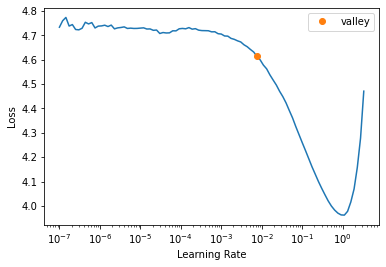

In [170]:
learn.lr_find()

In [173]:
learn.fit_one_cycle(5, 1e-2)

/Users/feng/opt/anaconda3/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
/Users/feng/opt/anaconda3/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.615870,4.536939,0.190789,93.404465,00:07
1,4.516165,4.319245,0.217928,75.131905,00:08
2,4.396584,4.155612,0.232730,63.790993,00:07
3,4.306918,4.078466,0.237664,59.054806,00:07
4,4.228493,4.061732,0.239309,58.074825,00:07


In [174]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2)

/Users/feng/opt/anaconda3/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
/Users/feng/opt/anaconda3/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.915982,4.679247,0.179276,107.688942,00:12
1,4.260599,4.045620,0.289474,57.146603,00:11
2,4.116689,3.561882,0.277961,35.229454,00:11
3,3.932480,3.406904,0.325658,30.171701,00:11
4,3.790564,3.372018,0.328947,29.137257,00:11


In [175]:
learn.save_encoder('/Users/feng/downloads/ArgumentAnnotatedEssays-2.0/finetuned')

In [176]:
dls_clas = TextDataLoaders.from_df(df_sample, path=path, text_col='text', label_col='label',text_vocab=dls_lm.vocab)
dls_clas.show_batch(max_n=3)

/Users/feng/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj is xxunk more xxunk than the xxunk xxunk ? \n\n xxunk a xxunk is xxunk a xxunk words xxunk is a xxunk xxunk that is being used for a very xxunk time . xxmaj this xxunk xxunk the xxunk of xxunk in xxunk xxunk , ideas , or xxunk to people . xxmaj xxunk , the importance of xxunk xxunk can never be xxunk as it is also another way of communication that is xxunk used . xxmaj hence ,",0
1,"xxbos xxmaj xxunk in transportation and communication like the xxunk and the phone \n\n xxmaj nowadays , everyone can see the xxunk of technology on their life , especially on the way of xxunk and communications such as the xxunk and the xxunk . xxmaj there are lots of other effects of growing technology on xxunk and communications , which are xxunk as xxunk . \n xxmaj first and foremost ,",0
2,"xxbos xxmaj technology xxunk on people \n\n xxmaj nowadays , the xxmaj xxunk has become like a small xxunk . xxmaj in the course of the last xxunk years , the way majority of people xxunk with each other has been xxunk xxunk because of technology . xxmaj but there are xxunk xxunk of xxunk whether it is positive or negative . xxmaj from my point of view ,",0


In [177]:
metrics=[accuracy,F1Score(average='macro')]
learn = text_classifier_learner(dls_clas, AWD_LSTM,drop_mult=0.2, metrics=metrics, path=path, wd=0.1, model_dir="/tmp/model/")

In [178]:
learn = learn.load_encoder('/Users/feng/downloads/ArgumentAnnotatedEssays-2.0/finetuned')

In [187]:
df_test = df_combined.sample(n=30, random_state=42)
df_test = df_test[['text','label','doc_id']]

In [195]:
get_predStr(df_test)
df_test

In [196]:
def predict(txt):
    with learn.no_bar(), learn.no_logging():
        return int(learn.predict(txt)[0])

In [208]:
df_test['predictions'] = df_test["text"].progress_apply(lambda x: predict(x))


# Adversarial Attacks Function

In [ ]:
#!pip install tensorflow_text
#!textattack list attack-recipes
#!pip install textattack
from textattack.augmentation import EmbeddingAugmenter,EasyDataAugmenter,WordNetAugmenter,CharSwapAugmenter,CheckListAugmenter,CLAREAugmenter
import time
t = df_combined.iloc[0].text
augmenter = CharSwapAugmenter()
augmenter.augment(t)

#     - WordNet synonym replacement
#         - Randomly replace words with their synonyms.
#     - Word deletion
#         - Randomly remove words from the sentence.
#     - Word order swaps
#         - Randomly swap the position of words in the sentence.
#     - Random synonym insertion
#         - Insert a random synonym of a random word at a random location.
augmenter = EasyDataAugmenter(pct_words_to_swap=0.2, transformations_per_example=1)
s = 'What I do not understand, I can not create.'
augmenter.augment(s)

In [133]:
def create_attacks(df,att_type,**kwargs):
    
    def easy_data(text):
        augmenter = EasyDataAugmenter(kwargs['pct_swap'], kwargs['num_trans'])
        return augmenter.augment(text)[0]
    def syno(text):
        augmenter = WordNetAugmenter()
        return augmenter.augment(text)[0]
    
    if att_type == "easy_data":
        df.text = df.text.apply(easy_data)
        
    elif att_type == "replace_synonym":
        df.text = df.text.apply(syno)
        

In [134]:
s = time.time()
create_attacks(df_combined.iloc[:5],att_type = "replace_synonym")
print(time.time()-s)

1.6966230869293213


# Prediction_String

In [193]:
def get_predStr(df):
    assert all(item in list(df) for item in ['label', 'text', 'doc_id']), "Please use a dataframe with correct columns"
    prediction_strings = []
    start_id = 1
    prev_doc = df.iloc[0].doc_id
    for (label, text, doc_id) in df[['label', 'text', 'doc_id']].itertuples(index=False):
        if doc_id != prev_doc:
            prev_doc = doc_id
            start_id = 1
        text_split = text.split()
        end_id = start_id + len(text_split)
        prediction_strings.append(
            [num for num in range(start_id, end_id)]
        )
        start_id = end_id   
    df['predictionString'] = prediction_strings